# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import os
import sys
from pathlib import Path
import time
import tempfile
import logging

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mne
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, LocalCluster

In [2]:
# packageroot = Path('../../').resolve()
packageroot = Path('/home/dongjp/source-code/PyEEG').resolve()
print(packageroot)
sys.path.append(str(packageroot))

from pythoneeg import core
from pythoneeg import visualization
from pythoneeg import constants

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

/home/dongjp/source-code/PyEEG


/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['DDFBinaryMetadata', 'LongRecordingOrganizer', 'convert_ddfcolbin_to_ddfrowbin', 'convert_ddfrowbin_to_si', 'convert_units_to_multiplier', 'convert_colpath_to_rowpath', 'filepath_to_index', 'is_day', 'set_temp_directory', 'get_temp_directory', 'LongRecordingAnalyzer', 'MountainSortAnalyzer', 'FragmentAnalyzer']


In [3]:
core.set_temp_directory('/scr1/users/dongjp')

In [4]:
tmpmet = core.DDFBinaryMetadata(r"/mnt/isilon/marsh_single_unit/PythonEEG Data Bins/A5 WT 12_12-2023/Cage 1 A5 -1_Meta.csv")
print(tmpmet.dt_end.ctime())
display(tmpmet.channel_names)

Tue Dec 12 12:57:00 2023


['Intan Input (1)/PortB L Aud Ctx',
 'Intan Input (1)/PortB L Vis Ctx',
 'Intan Input (1)/PortB L Hipp',
 'Intan Input (1)/PortB L Barrel',
 'Intan Input (1)/PortB L Motor',
 'Intan Input (1)/PortB R Motor',
 'Intan Input (1)/PortB R Barrel',
 'Intan Input (1)/PortB R Hipp',
 'Intan Input (1)/PortB R Vis Ctx',
 'Intan Input (1)/PortB R Aud Ctx']

In [5]:
data_folder = Path('./test-data').resolve()
lrec = core.LongRecordingOrganizer(base_folder_path= data_folder / 'A10 KO 12_13_2023',
                                    truncate=3)
lrec.convert_colbins_to_rowbins(overwrite=False)
lrec.convert_rowbins_to_rec()

/home/dongjp/source-code/PyEEG/pythoneeg/core/core.py:153: UserWarning: truncate = True. Only the first 3 files of each animal will be used
  warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")


In [6]:
Path('./test-wars/A5').resolve()

PosixPath('/home/dongjp/source-code/PyEEG/notebooks/tests/test-wars/A5')

In [7]:
cluster_window = SLURMCluster(
        cores=8,
        processes=1, # Threaded parallelization works best for WAR
        memory='20GB',
        walltime='12:00:00',
        interface=None,
        scheduler_options={'interface': 'eth1'},
        job_extra_directives=['--output=/dev/null',
                             '--error=/dev/null']
    )
cluster_window.scale(jobs=15)  # Scale to 16 workers
display(cluster_window)
cluster_window.wait_for_workers(15)

Dashboard: http://172.16.7.58:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.7.58:38235,Workers: 0
Dashboard: http://172.16.7.58:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
# cluster_spike = SLURMCluster(
#         cores=1,
#         memory='10GB',
#         processes=1,
#         walltime='12:00:00',
#         interface=None,
#         scheduler_options={'interface': 'eth1'},
#         job_extra_directives=['--output=/dev/null',
#                              '--error=/dev/null']
#     )
# cluster_spike.scale(10)
# display(cluster_spike)
# cluster_spike.wait_for_workers(10)

In [9]:
# Set up logger with detailed formatting
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG, stream=sys.stdout, force=True)
logger = logging.getLogger()


In [10]:
# %%script true
# animal_ids = ['A5', 'A10', 'F22', 'G25', 'G26', 'N21', 'N22', 'N23', 'N24', 'N25']
# animal_ids = ['A5']
animal_ids = ['A10', 'F22']
# animal_ids = ['F22']
# animal_ids = ['G25']
base_folder = Path('./test-data').resolve()
# base_folder = Path('/mnt/isilon/marsh_single_unit/PythonEEG Data Bins').resolve()
for animal_id in animal_ids:
    ao = visualization.AnimalOrganizer(base_folder, animal_id, mode="concat", assume_from_number=True, truncate=False)
    ao.convert_colbins_to_rowbins(overwrite=False)
    ao.convert_rowbins_to_rec() # parallelization breaks if not enough memory

    with Client(cluster_window) as client:
        client.upload_file(str(packageroot / 'pythoneeg.zip'))
        display(client)
        print("running war")
        ao.convert_rowbins_to_rec(multiprocess_mode='dask') # paralleization breaks if not enough memory
        war = ao.compute_windowed_analysis(['all'], multiprocess_mode='dask')
        # war.save_pickle_and_json(Path(f'./test-wars-full/{animal_id}').resolve())

    # with Client(LocalCluster()) as client:
    #     client.upload_file(str(packageroot / 'pythoneeg.zip'))
    #     display(client)
    #     print("running sar")
    #     sar = ao.compute_spike_analysis(multiprocess_mode='dask')

Converting column bins to row bins:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-31 18:14:33,688 - WARNING - Row-major binary files already exist! Skipping existing files


Converting row bins to recs: 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]


<Client: 'tcp://172.16.7.58:38235' processes=15 threads=120, memory=279.45 GiB>

running war


Converting row bins to recs: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]

2025-03-31 18:14:37,915 - DEBUG - Initializing LongRecordingAnalyzer for /home/dongjp/source-code/PyEEG/notebooks/tests/test-data/A10 KO 12_13_2023
2025-03-31 18:14:37,916 - DEBUG - Processing 31 fragments
2025-03-31 18:14:37,917 - DEBUG - Converting LongRecording to numpy array
2025-03-31 18:14:37,948 - DEBUG - Caching numpy array with h5py in /scr1/users/dongjp/temp_a49325d7fca8734947d3dc1da63f70b49c8b0efc096d2bd4.h5
2025-03-31 18:14:38,044 - DEBUG - Processing metadata serially
2025-03-31 18:14:38,048 - DEBUG - Processing features in parallel


2025-03-31 18:14:48,613 - DEBUG - Cleaning up temp file
2025-03-31 18:14:48,623 - DEBUG - Combining metadata and feature values
2025-03-31 18:14:48,630 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 18:14:48,631 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 18:14:48,635 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 18:14:48,641 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 18:14:48,642 - WARNING - Intan Input (1)/PortC C-015 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 18:14:48,644 - WARNING - Intan Input (1)/PortC C-016 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 18:14:48,645 - WARNING - Intan Input (1

Converting column bins to row bins:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-31 18:14:48,692 - WARNING - Row-major binary files already exist! Skipping existing files


Converting row bins to recs: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


<Client: 'tcp://172.16.7.58:38235' processes=15 threads=120, memory=279.45 GiB>

running war


Converting row bins to recs: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

2025-03-31 18:14:49,801 - DEBUG - Initializing LongRecordingAnalyzer for /home/dongjp/source-code/PyEEG/notebooks/tests/test-data/F22 KO 12_12_2023
2025-03-31 18:14:49,802 - DEBUG - Processing 117 fragments
2025-03-31 18:14:49,803 - DEBUG - Converting LongRecording to numpy array
2025-03-31 18:14:49,925 - DEBUG - Caching numpy array with h5py in /scr1/users/dongjp/temp_1dab842c0da0502b19cca58e3ab56b3c3d9a03384ec7a4c3.h5


2025-03-31 18:14:50,135 - DEBUG - Processing metadata serially
2025-03-31 18:14:50,145 - DEBUG - Processing features in parallel
2025-03-31 18:14:56,811 - DEBUG - Cleaning up temp file
2025-03-31 18:14:56,823 - DEBUG - Combining metadata and feature values
2025-03-31 18:14:56,829 - WARNING - Intan Input (1)/PortD D-009 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 18:14:56,830 - WARNING - Intan Input (1)/PortD D-010 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 18:14:56,831 - WARNING - Intan Input (1)/PortD D-012 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 18:14:56,832 - WARNING - Intan Input (1)/PortD D-014 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 18:14:56,838 - WARNING - Intan Input (1)/PortD D-015 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 18:14:56,839 - WARNING - Intan Input (1)/PortD 

In [11]:
war = visualization.WindowAnalysisResult.load_pickle_and_json(Path('./test-wars/F22').resolve())

2025-03-31 16:19:16,771 - WARNING - Intan Input (1)/PortD D-009 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:16,772 - WARNING - Intan Input (1)/PortD D-010 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:16,773 - WARNING - Intan Input (1)/PortD D-012 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:16,773 - WARNING - Intan Input (1)/PortD D-014 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:16,774 - WARNING - Intan Input (1)/PortD D-015 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:16,775 - WARNING - Intan Input (1)/PortD D-016 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:16,781 - WARNING - Intan Input (1)/PortD D-017 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:16,782 - WARNING - Intan

In [12]:
war.get_result(['all'], allow_missing=True).head(3)

,index,animalday,animal,day,genotype,duration,endfile,timestamp,isday,rms,ampvar,psd,psdtotal,psdband,psdfrac,psdslope,cohere,pcorr
0,0,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:13.560,True,"[324.54126, 123.114975, 89.73853, 199.99457, 3...","[98233.31, 14860.118, 7970.6294, 37275.664, 15...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[2991.1634385554166, 9655.58377513804, 4896.79...","{'delta': [2371.695324738739, 3296.14610609939...","{'delta': [0.7929006132423677, 0.3413720167377...","[[-1.6266363283601732, 3.0386960730587895], [-...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:17.560,True,"[33.98209, 98.85394, 73.50655, 72.370285, 407....","[1154.7565, 9768.589, 5399.9756, 5234.582, 165...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[617.6503225177026, 8764.378583594078, 4536.85...","{'delta': [190.0428130962193, 1800.43295303487...","{'delta': [0.3076867382203503, 0.2054261960346...","[[-1.2730235496671296, 2.4032617509449405], [-...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:21.560,True,"[39.47056, 100.14916, 70.84106, 86.55565, 620....","[1557.7701, 10023.703, 5018.388, 7481.0225, 38...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[808.7404621241202, 7759.685803861311, 3899.87...","{'delta': [306.9726448654066, 2821.06366983401...","{'delta': [0.3795687977069391, 0.3635538527127...","[[-1.4760446379997991, 2.664199600531952], [-1...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


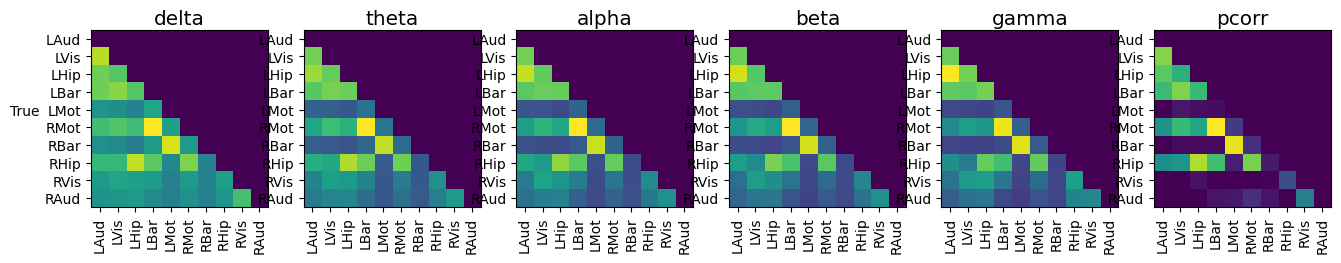

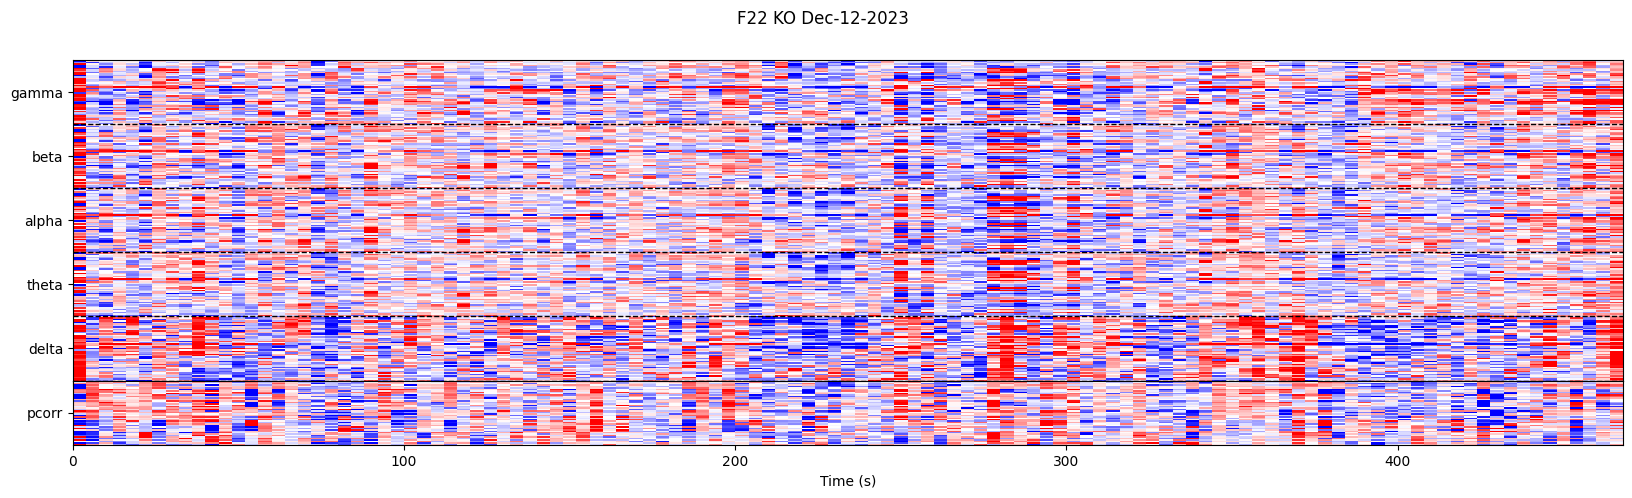

/home/dongjp/source-code/PyEEG/pythoneeg/visualization/plotting/animal.py:325: RuntimeWarning: divide by zero encountered in log10
  ax[0, i].plot(freqs, 10**(b + m * np.log10(freqs)), c=f'C{j}', alpha=0.75)


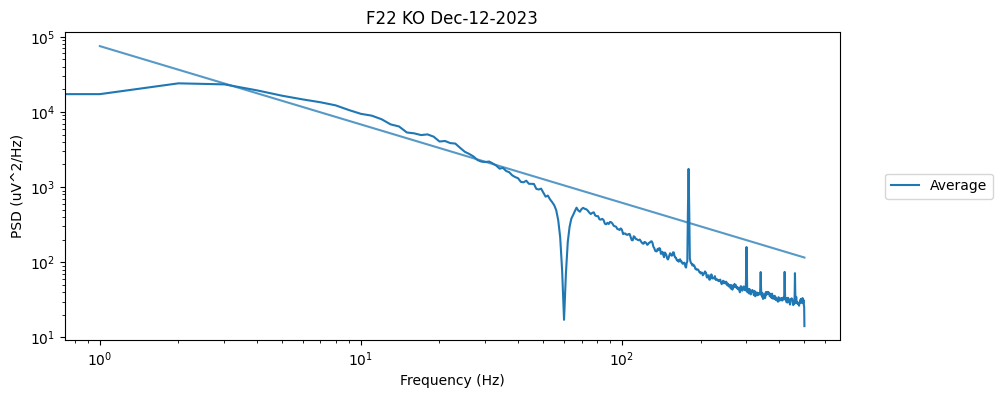

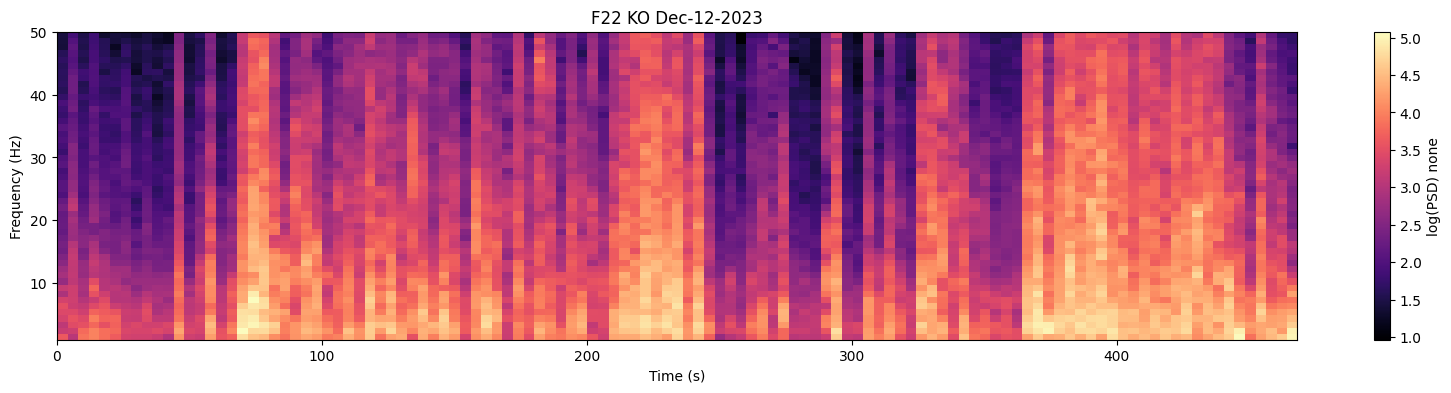

In [13]:
logger.setLevel(logging.WARNING)
ap = visualization.AnimalPlotter(war)
ap.plot_coherecorr_matrix(['isday'], bands=None, figsize=(16,5), cmap='viridis')
# ap.plot_coherecorr_diff(['isday'], bands=None, figsize=(16,5))
# ap.plot_linear_temporal(figsize=(20, 5), score_type='z', lw=1, channels=[0, 1])
# ap.plot_linear_temporal(['isday'], figsize=(20, 5), score_type='z', lw=1, channels=[0, 1, 2, 3])

# ap.plot_coherecorr_spectral(['isday'], figsize=(20, 5), score_type='center')

ap.plot_coherecorr_spectral(figsize=(20, 5), score_type='center')
ap.plot_psd_histogram(figsize=(10, 4), avg_channels=True, plot_type='loglog')
ap.plot_psd_spectrogram(figsize=(20, 4), mode='none')

In [14]:
logger.setLevel(logging.DEBUG)
wars = []
animal_ids = ['A10', 'F22']
for animal_id in animal_ids:
    war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())
    # logging.critical(war.result.iloc[0]['pcorr'])
    # war = war.filter_all()
    # logging.critical(war.result.iloc[0]['pcorr'])
    wars.append(war)
ep = visualization.ExperimentPlotter(wars)


2025-03-31 16:19:19,407 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.


2025-03-31 16:19:19,411 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:19,416 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:19,416 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:19,417 - WARNING - Intan Input (1)/PortC C-015 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:19,418 - WARNING - Intan Input (1)/PortC C-016 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:19,419 - WARNING - Intan Input (1)/PortC C-017 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:19,420 - WARNING - Intan Input (1)/PortC C-019 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:19,421 - WARNING - Intan

In [15]:
for feat in constants.LINEAR_FEATURE:
    logging.info(f'pulling {feat}')
    ep._pull_timeseries_dataframe(feat, ['genotype','animalday'])

2025-03-31 16:19:19,480 - INFO - pulling rms
2025-03-31 16:19:19,499 - DEBUG - groups: [('KO', 'A10 KO Dec-13-2023'), ('KO', 'F22 KO Dec-12-2023')]
2025-03-31 16:19:19,501 - DEBUG - vals.shape: (31, 10)
2025-03-31 16:19:19,504 - DEBUG - vals.shape: (117, 10)
2025-03-31 16:19:19,526 - INFO - pulling ampvar
2025-03-31 16:19:19,528 - DEBUG - groups: [('KO', 'A10 KO Dec-13-2023'), ('KO', 'F22 KO Dec-12-2023')]
2025-03-31 16:19:19,529 - DEBUG - vals.shape: (31, 10)
2025-03-31 16:19:19,531 - DEBUG - vals.shape: (117, 10)
2025-03-31 16:19:19,534 - INFO - pulling psdtotal
2025-03-31 16:19:19,536 - DEBUG - groups: [('KO', 'A10 KO Dec-13-2023'), ('KO', 'F22 KO Dec-12-2023')]
2025-03-31 16:19:19,537 - DEBUG - vals.shape: (31, 10)
2025-03-31 16:19:19,538 - DEBUG - vals.shape: (117, 10)
2025-03-31 16:19:19,542 - INFO - pulling psdslope
2025-03-31 16:19:19,544 - DEBUG - groups: [('KO', 'A10 KO Dec-13-2023'), ('KO', 'F22 KO Dec-12-2023')]
2025-03-31 16:19:19,544 - DEBUG - vals.shape: (31, 10, 2)
2025

2025-03-31 16:19:19,618 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f0dd070f550>
2025-03-31 16:19:19,665 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f0dd0570e80>
2025-03-31 16:19:20,080 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f0dd0cdbe50>
2025-03-31 16:19:20,147 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f0de8855240>
2025-03-31 16:19:20,199 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f0de858b010>
2025-03-31 16:19:20,258 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f0dd2f40ca0>
2025-03-31 16:19:20,332 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f0de887c040>


(<Figure size 800x1500 with 15 Axes>,
 array([[<Axes: title={'center': 'A10'}, ylabel='delta'>,
         <Axes: title={'center': 'F22'}>],
        [<Axes: ylabel='theta'>, <Axes: >],
        [<Axes: ylabel='alpha'>, <Axes: >],
        [<Axes: ylabel='beta'>, <Axes: >],
        [<Axes: ylabel='gamma'>, <Axes: >]], dtype=object),
 None)

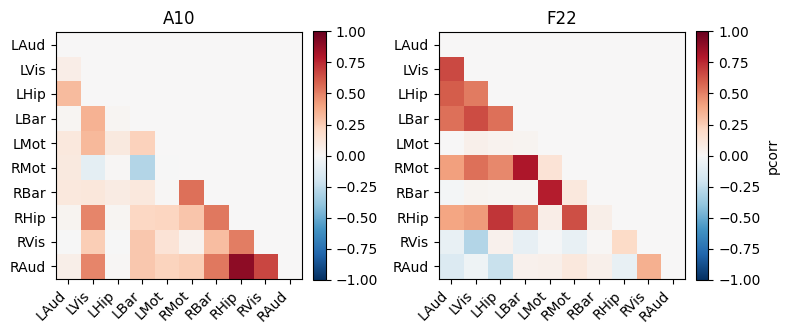

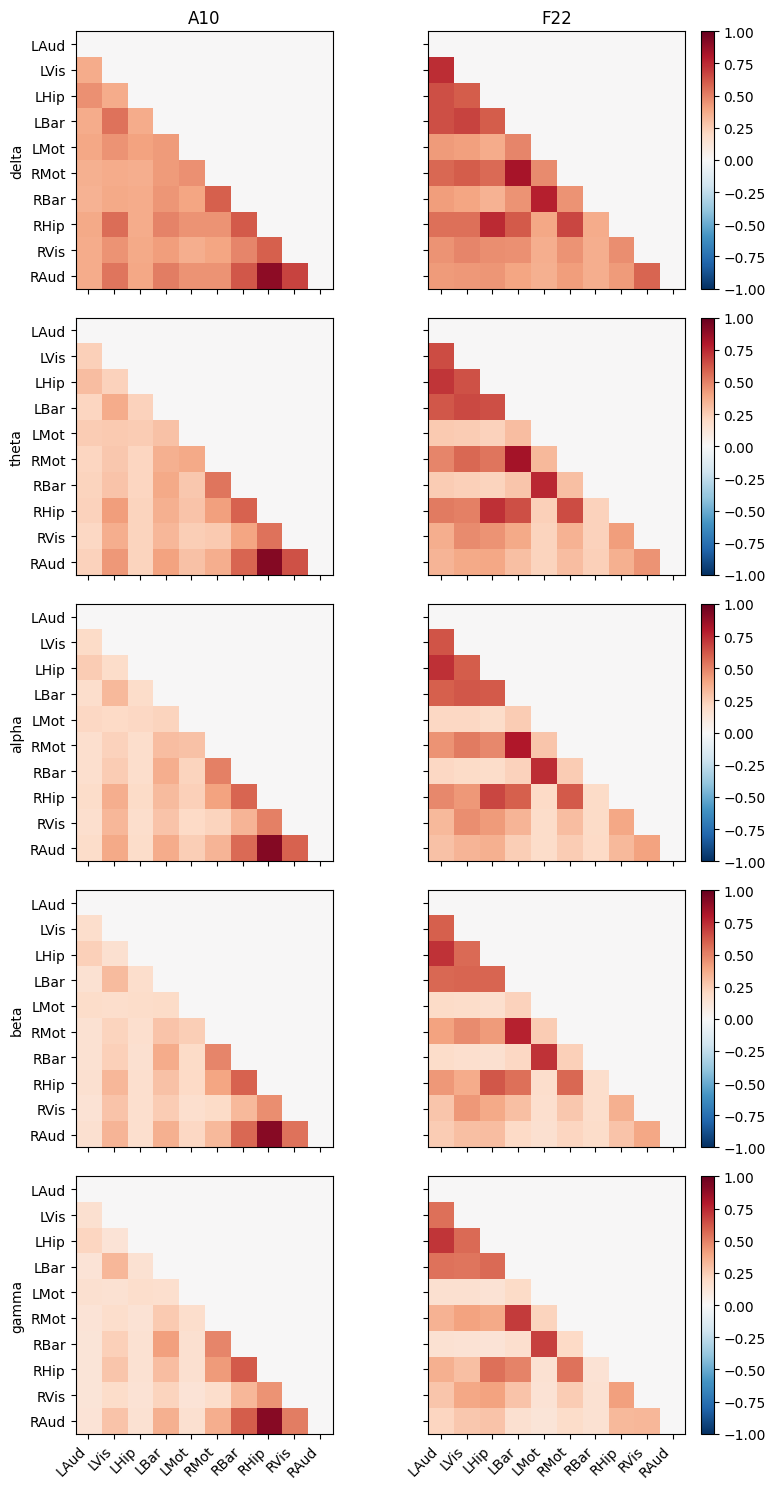

In [16]:

# ep.plot_boxplot('rms')
# ep.plot_violin('rms')
# ep.plot_scatter('rms')
ep.plot_2d_feature('pcorr', xgroup='animal')
ep.plot_2d_feature_freq('cohere', xgroup='animal')

2025-03-31 16:19:22,297 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:22,298 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:22,299 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:22,299 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:22,300 - WARNING - Intan Input (1)/PortC C-015 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:22,300 - WARNING - Intan Input (1)/PortC C-016 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:22,302 - WARNING - Intan Input (1)/PortC C-017 does not match name aliases. Assuming alias from number in channel name.
2025-03-31 16:19:22,303 - WARNING - Intan

(<Figure size 800x1500 with 15 Axes>,
 array([[<Axes: title={'center': 'A10'}, ylabel='delta'>,
         <Axes: title={'center': 'F22'}>],
        [<Axes: ylabel='theta'>, <Axes: >],
        [<Axes: ylabel='alpha'>, <Axes: >],
        [<Axes: ylabel='beta'>, <Axes: >],
        [<Axes: ylabel='gamma'>, <Axes: >]], dtype=object),
 None)

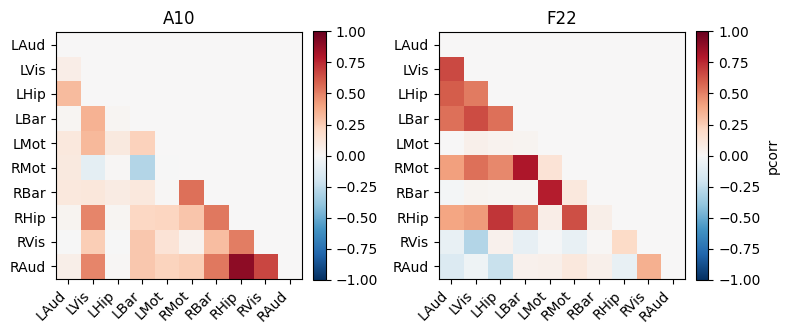

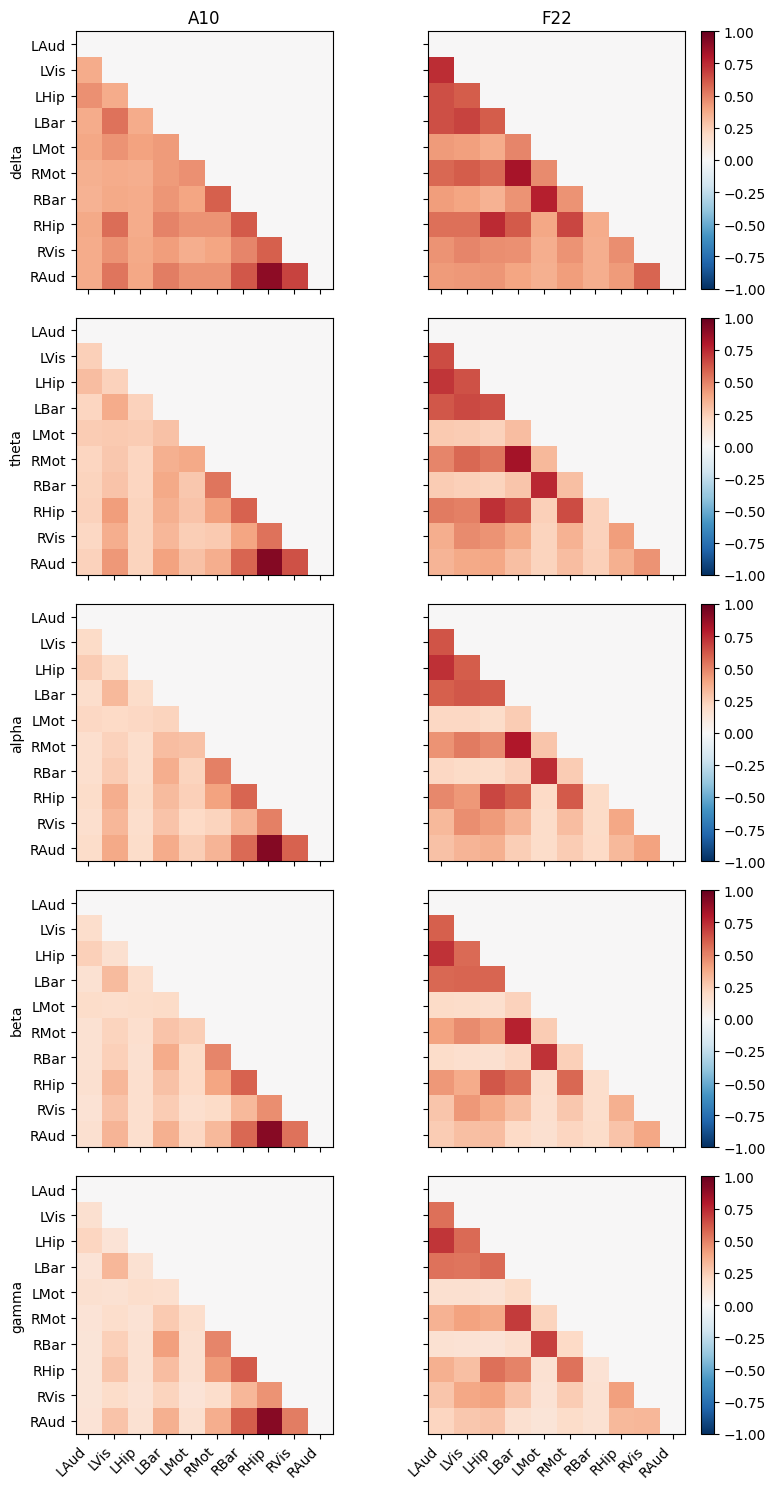

In [17]:
logger.setLevel(logging.DEBUG)
wars = []
animal_ids = ['A10', 'F22']
for animal_id in animal_ids:
    war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())
    # logging.critical(war.result.iloc[0]['pcorr'])
    # war = war.filter_all()
    # logging.critical(war.result.iloc[0]['pcorr'])
    wars.append(war)
ep = visualization.ExperimentPlotter(wars)


# ep.plot_boxplot('rms')
# ep.plot_violin('rms')
# ep.plot_scatter('rms')
ep.plot_2d_feature('pcorr', xgroup='animal')
ep.plot_2d_feature_freq('cohere', xgroup='animal')

In [18]:
logger.setLevel(logging.DEBUG)

In [19]:
for e in sar:
    e.convert_to_mne(chunk_len=1440)
    e.save_fif_and_json(Path(f'./test-mnes/{e.animal_day}').resolve(), overwrite=True)

NameError: name 'sar' is not defined

In [17]:
reconstruct_sas = visualization.SpikeAnalysisResult.load_fif_and_json('./test-mnes/A5 WT Dec-12-2023')
mne_obj = reconstruct_sas.result_mne

Opening raw data file test-mnes/A5 WT Dec-12-2023/A5-WT-A5 WT Dec-12-2023-raw.fif...
    Reading extended channel information
Isotrak not found
    Range : 0 ... 40067758 =      0.000 ... 40067.758 secs
Ready.
2025-03-21 21:23:35,173 - INFO - Channel names: 	['Intan Input (1)/PortB L Aud Ctx', 'Intan Input (1)/PortB L Vis Ctx', 'Intan Input (1)/PortB L Hipp', 'Intan Input (1)/PortB L Barrel', 'Intan Input (1)/PortB L Motor', 'Intan Input (1)/PortB R Motor', 'Intan Input (1)/PortB R Barrel', 'Intan Input (1)/PortB R Hipp', 'Intan Input (1)/PortB R Vis Ctx', 'Intan Input (1)/PortB R Aud Ctx']
2025-03-21 21:23:35,174 - INFO - Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]


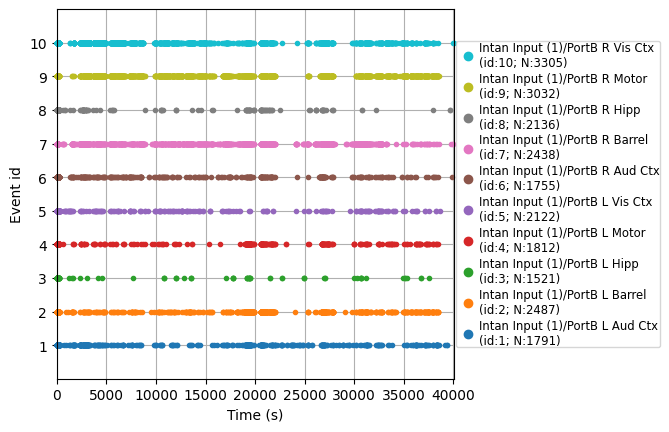

In [18]:
logger.setLevel(logging.WARNING)
events, event_id = mne.events_from_annotations(raw=mne_obj)
fig = mne.viz.plot_events(events, sfreq=mne_obj.info['sfreq'], first_samp=mne_obj.first_samp, event_id=event_id)